# Machine-Learning Techniques for Clustering and Visualisation

In this notebook, we will perform clustering using the k-Prototypes algorithm, which is suitable for mixed data; we will treat our one-hotted cuisine categories as categorical variables, and our price and GPS coords as numerical variables. We will not cluster on ratings, as we don't want to recommend people poorly-rated restaurants on purpose.

We will then use a machine learning-based visualisation method (UMAP dimensionsionality reduction). Dimensionality reduction means that it will reduce our data to two variables, which may then be plotted together on a graph; this reduction will be done in a way which roughly preserves distances. We may thus then visualise the whole dataset as a scatterplot on a 2D plane, identifying the presence of clusters visually.

We will also perform more mundane visualisation using Seaborn.

## Initialize Libraries

Note: You may need to install kmodes if it is not already installed

In [1]:
%pip install kmodes -q
%pip install umap-learn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from kmodes.kprototypes import KPrototypes
import pickle

## Loading dataset

We will be using the dataset onehotted.csv that was generated after the data cleaning process and one-hotting of cuisines.

In [4]:
#Initialise dataset
restaurant_data = pd.read_csv('../Data/cleaned_onehotted.csv').iloc[: , 1:]
cuisines = pd.read_csv('../Data/cuisines.csv')
restaurant_data.head(2)

,name,rating,latitude,longitude,price,cuisine_cats,mult_cuisines,Asian Variety,Multi-Cuisine,Korean,...,Western Variety,Vietnamese,Beijing,Russian,Foochow,Hakka,Caribbean,Filipino,Irish,Dong Bei
0,1-V:U,3.5,1.252299,103.820211,40.5,[0],0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10 At Claymore,4.0,1.307401,103.829904,65.5,[1],0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Clustering

### Preprocessing

We create a new dataframe containing all values relevant to the clustering algorithm.

We also do min-max scaling to normalise our numerical variables, as many clustering algorithms, including K-Prototypes, are highly sensitive to scale differences in data.

In [5]:
#Group relevant columns for K-Prototype
df_K = pd.DataFrame()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_K[['latitude', 'longitude', 'price']] = scaler.fit_transform(
    restaurant_data[['latitude', 'longitude', 'price']]
)

df_K = df_K.join(restaurant_data[restaurant_data.columns[7:]])
df_K.head(2)

,latitude,longitude,price,Asian Variety,Multi-Cuisine,Korean,Belgian,Singaporean,Chinese,Cantonese,...,Western Variety,Vietnamese,Beijing,Russian,Foochow,Hakka,Caribbean,Filipino,Irish,Dong Bei
0,0.040402,0.452707,0.090909,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.286747,0.483832,0.154040,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We then convert the dataframe to a Numpy array to be fed into the K-Prototypes algorithm.

In [6]:
#Convert to array
array_K = df_K.to_numpy(dtype=float)
categorical_index = [i for i in range(3, 3+len(restaurant_data.columns[7:]))]

### Plotting the Elbow Curve

The K-Prototypes algorithm requires us to tell it how many clusters it should find. We will manually perform this "hyperparameter tuning", running K-Prototypes with varying numbers of clusters and plotting the cost function on the y-axis. This will produce an "elbow curve", on which we will look for the inflection point, i.e. the point after which the reduction in cost function from adding more clusters becomes small.

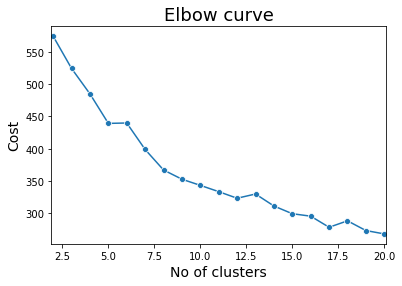

In [7]:
from os.path import exists
models = []
if exists("..\Data\models.pickle"):
    with open("..\Data\models.pickle","rb") as f:
        models = pickle.load(f)

# Function for plotting elbow curve
def plot_elbow_curve(start, end, data):    
    no_of_clusters = list(range(start, end+1))
    
    if not models:
        for k in no_of_clusters:
            print("{} clusters step started".format(k))
            test_model = KPrototypes(n_clusters=k, init='Huang', random_state=42, n_jobs=-1)
            test_model.fit_predict(data, categorical=categorical_index)
            models.append(test_model)
            print("{} clusters step done".format(k))
        
    cost_values = [i.cost_ for i in models]
            
    ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
    ax.set_title('Elbow curve', fontsize=18)
    ax.set_xlabel('No of clusters', fontsize=14)
    ax.set_ylabel('Cost', fontsize=14)
    ax.set(xlim=(start-0.1, end+0.1))
    
# Plotting elbow curve for k=2 to k=20
plot_elbow_curve(2,20,df_K[['latitude', 'longitude', 'price', *restaurant_data.columns[7:]]])

Our inflection point appeals to be at about 12 clusters. We will thus use the results of running K-Prototypes with 12 clusters going ahead.

### Postprocessing of clusters

We will use our model to label our datapoints, `df_K`, with the cluster they belong to. We will then store in `df_K_clusters` the 12 clusters we founds; for each cluster, we will store the mean price, latitude, and longitude of the data-points labelled with it, and a list containing the distribution of cuisines in the cluster, with the number of repeats of cuisine labels corresponding to the number of data-points labelled with the cluster which contained the cuisine.

In [8]:
kprototype = models[10]
kprototype.labels_

array([2, 2, 2, ..., 2, 1, 6], dtype=uint16)

In [9]:
def inttoord(n):
    return "%d%s" % (n+1,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

# For Jupyter convenience
todrop=[i for i in ['Labels', 'Segment', 'Total'] if i in df_K.columns]
df_K = df_K.drop(todrop,axis=1)
# Add the cluster to the dataframe
df_K['Labels'] = kprototype.labels_
df_K['Segment'] = df_K['Labels'].map(inttoord)

In [10]:
# Cluster interpretation
df_K['Total'] = pd.DataFrame(df_K['Labels'])
df_K['cuisine_cats'] = df_K[restaurant_data.columns[7:]].apply(
    lambda x: [i for i in range(len(x[7:])) if x[7+i]]
    ,axis=1)
df_K_dropped = df_K.drop(columns=restaurant_data.columns[7:])
from statistics import mode
df_K_clusters = df_K_dropped.groupby('Segment').agg(
    {
        'Labels':'mean',
        'Total':'count',
        'cuisine_cats': lambda x: [j for i in x.items() for j in i[1]],
        'latitude': 'mean',
        'longitude': 'mean',
        'price': 'mean'
    }, axis=1
).sort_values(by=['Labels']).reset_index()

`df_K_clusters[cuisine_cats]` is designed for easy visualisation using Seaborn histograms, thus the useage of repeated cuisine labels to indicate the number of data-points which were both (1) tagged with the cluster and (2) tagged with the cuisine.

### Analysis of our clusters

We can't be sure yet that we've captured anything meaningful. Let's take a look inside our clusters.

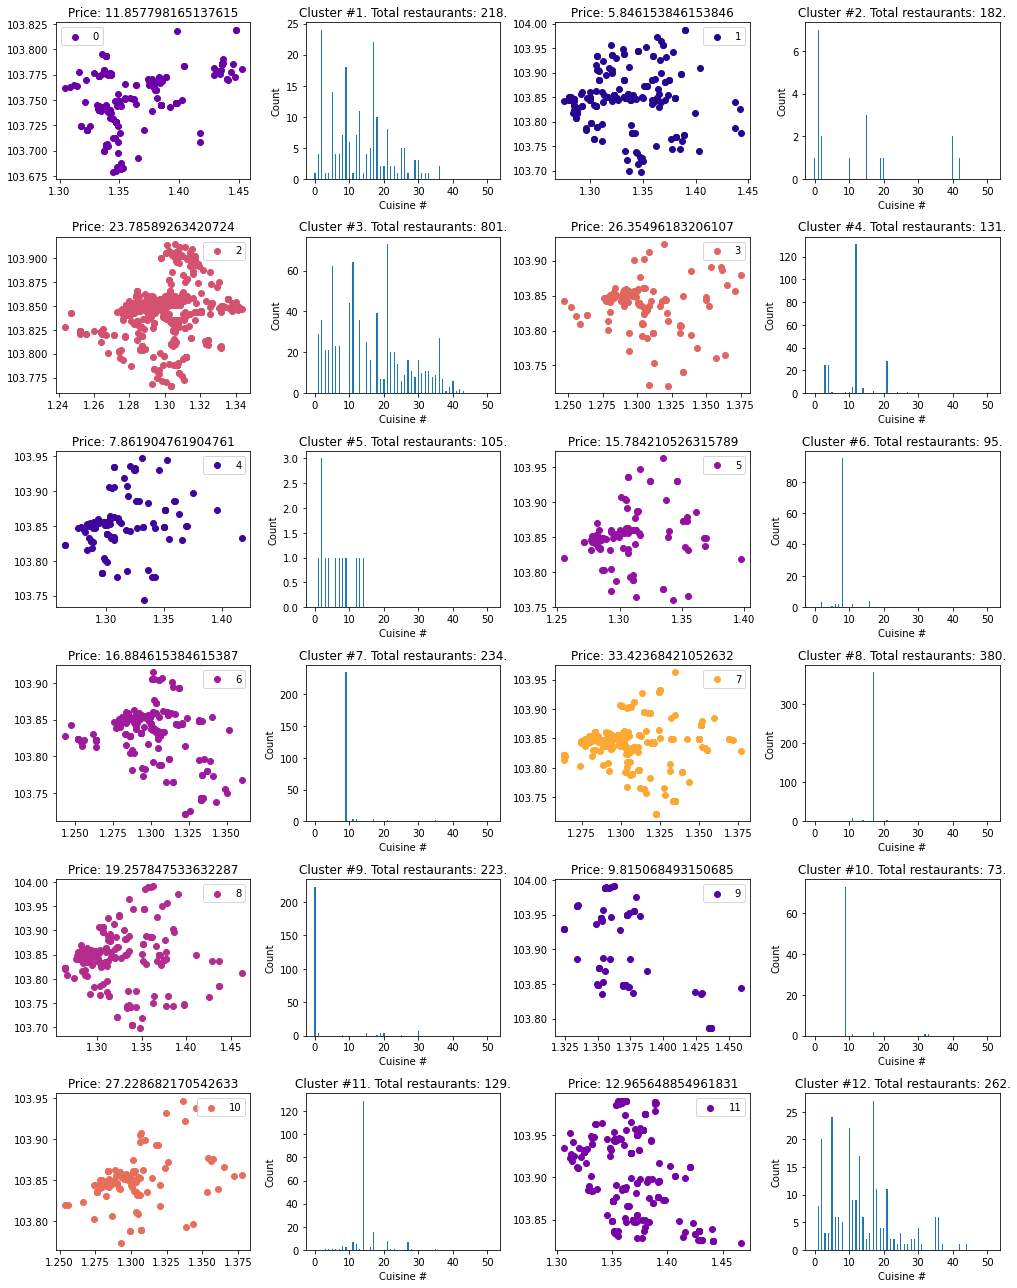

In [36]:
import matplotlib.pyplot as plt
from math import ceil
from collections import Counter
ncols = 4

fig, axes = plt.subplots(nrows=ceil(len(df_K_clusters)/2), ncols=4, figsize=(14,3*ceil(len(df_K_clusters)/2)))

for idx, row in df_K_clusters.iterrows():
    r_cuisines = Counter(row['cuisine_cats'])
    countslist = []
    for i in range(len(cuisines)):
        if i not in r_cuisines:
            countslist.append(0)
        else:
            countslist.append(r_cuisines[i])
    ax = axes[idx//2][(2*(idx%2))+1]
    ax.bar(range(len(cuisines)), countslist, 0.35)
    ax.set_ylabel("Count")
    ax.set_xlabel("Cuisine #")
    ax.set_title("Cluster #{}. Total restaurants: {}.".format(idx+1, row['Total']))
    
untransformed = pd.DataFrame(
    scaler.inverse_transform(df_K_dropped[['latitude', 'longitude', 'price']]),
    columns = ['latitude', 'longitude', 'price']
)
untransformed['Labels'] = df_K_dropped['Labels']
df = untransformed

u_labels = np.unique(df['Labels'])
clus_back = pd.DataFrame(scaler.inverse_transform(df_K_clusters[['latitude', 'longitude', 'price']]),
                         columns=['latitude', 'longitude', 'price'])
clus_back['Labels'] = df_K_clusters['Labels']

from matplotlib import cm, colors
norm = colors.Normalize(vmin=df['price'].quantile(0.1), vmax=df['price'].quantile(0.9), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.plasma)

for idx, row in df_K_clusters.iterrows():
    ax = axes[idx//2][2*(idx%2)]
    #for i in u_labels[:idx+1]:
    ax.scatter(df[df.Labels==u_labels[idx]]['latitude'],
               df[df.Labels==u_labels[idx]]['longitude'],
               label = u_labels[idx],
               color=colors.to_hex(mapper.to_rgba(clus_back[clus_back.Labels==u_labels[idx]]['price'])))
    ax.title.set_text("Price: {}".format(clus_back[clus_back.Labels==u_labels[idx]]['price'].iloc[0]))
    ax.legend()

fig.tight_layout()
fig.savefig(r"..\Data\visualisation.png", facecolor='white', edgecolor='none')
plt.show()

From a cursory examination, it looks like our clusters are quite varied with regards to geographic location, price, and cuisine. It's a bit hard to read so many plots, though. Let's try our next visualisation.

## UMAP Visualisation

We will use UMAP dimensionality reduction to visualise our data with and without the clustering results.

In [14]:
df_umap = pd.DataFrame()
df_umap = restaurant_data[['latitude', 'longitude', 'price']]\
    .join(restaurant_data[restaurant_data.columns[7:]].astype(np.dtype('uint8')))

In [26]:
import umap
from sklearn.preprocessing import PowerTransformer

full_data = df_umap

#Preprocessing numerical
numerical = full_data.select_dtypes(exclude='uint8')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = full_data.select_dtypes(include='uint8')
categorical.columns = ["cuisine_" + i for i in categorical.columns]
#categorical = pd.get_dummies(categorical)

#Get weightage from our K-Prototypes algorithms
categorical_weight = 1-models[10].gamma

#Define the K-Prototypes categorical distance metric, which is just the number of mismatches
#UMAP wants us to JIT compile to machine code using Numba for performance reasons
from numba import jit
@jit
def n_mismatches(arr_a, arr_b):
    return float(np.sum(np.logical_xor(arr_a, arr_b)))

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='euclidean').fit(numerical)
fit2 = umap.UMAP(metric=n_mismatches).fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)

embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, {}, False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

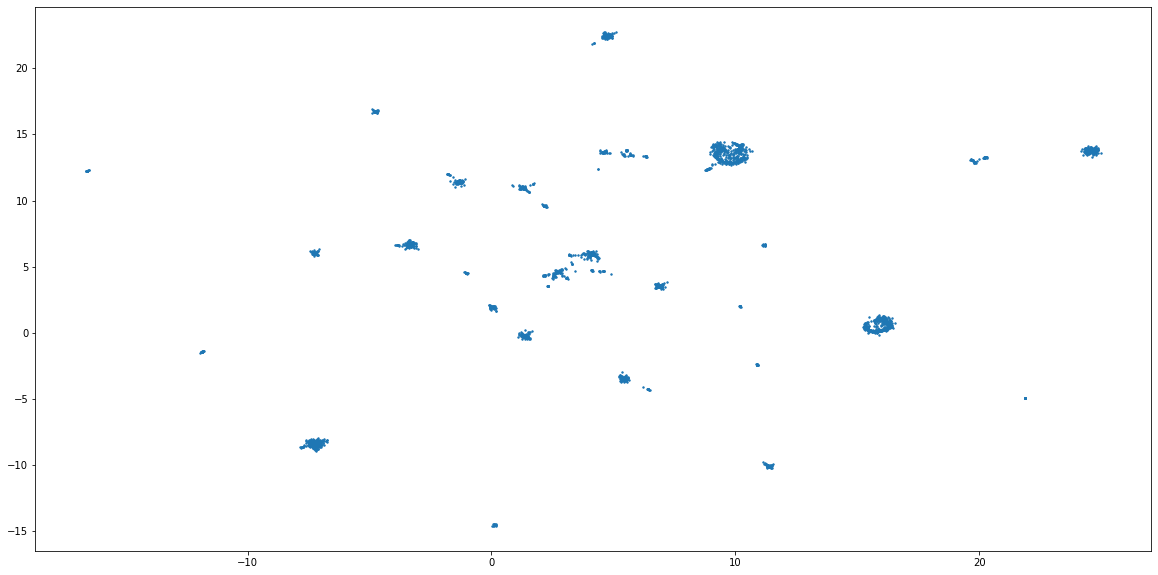

In [37]:
plt.figure(figsize=(20, 10))
plt.scatter(embedding[0][:,0], embedding[0][:,1], s=2, cmap='Spectral', alpha=1.0)
gcf = plt.gcf() #so our figure isn't lost
plt.show()
gcf.savefig(r"../Data/visualisation2.png")

Looks like we have some clear natural clustering in our data.

What does it look like after we colourise the datapoints according to the cluster we assigned them?

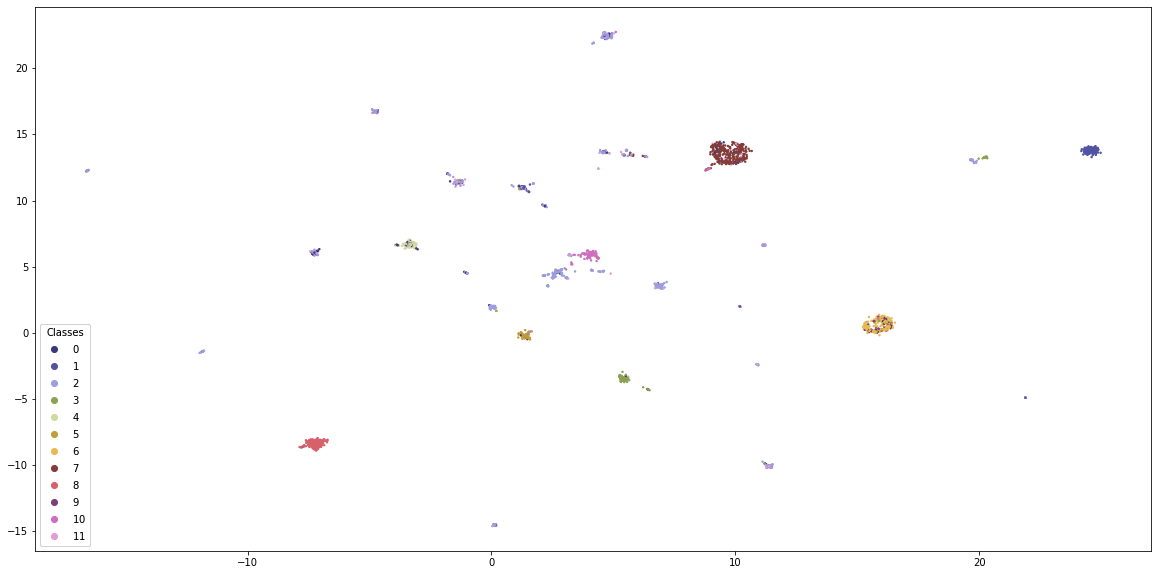

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[0][:,0], embedding[0][:,1], s=2, c=kprototype.labels_, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=12),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
fig.savefig(r"../Data/visualisation3.png")

Success! Our k-prototypes algorithm has very distinctly coloured the different clusters we previously visually identified.

### Dumping our data

Our machine learning stuff here takes a while to run, so we're going to use Python's pickle functionality to serialise our models to files, so we can avoid rerunning them.

In [33]:
with open('..\Data\models.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('..\Data\df_K_clusters.pickle', 'wb') as handle:
    pickle.dump(df_K_clusters, handle, protocol=pickle.HIGHEST_PROTOCOL)